In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import tensorwatch as tw

In [2]:
class TripletFolder(datasets.ImageFolder):

    def __init__(self, root, transform):
        super(TripletFolder, self).__init__(root, transform)
        targets = np.asarray([s[1] for s in self.samples])
        self.targets = targets
        cams = []
        for s in self.samples:
            cams.append( self._get_cam_id(s[0]) )
        self.cams = np.asarray(cams)

    def _get_cam_id(self, path):
        camera_id = []
        filename = os.path.basename(path)
        camera_id = filename.split('c')[1][0]
        #camera_id = filename.split('_')[2][0:2]
        return int(camera_id)-1

    def _get_pos_sample(self, target, index):
        pos_index = np.argwhere(self.targets == target)
        pos_index = pos_index.flatten()
        pos_index = np.setdiff1d(pos_index, index)
        rand = np.random.permutation(len(pos_index))
        result_path = []
        for i in range(4):
            t = i%len(rand)
            tmp_index = pos_index[rand[t]]
            result_path.append(self.samples[tmp_index][0])
        return result_path

    def _get_neg_sample(self, target):
        neg_index = np.argwhere(self.targets != target)
        neg_index = neg_index.flatten()
        rand = random.randint(0,len(neg_index)-1)
        return self.samples[neg_index[rand]]

    def __getitem__(self, index):
        path, target = self.samples[index]
        cam = self.cams[index]
        # pos_path, neg_path
        pos_path = self._get_pos_sample(target, index)

        sample = self.loader(path)
        pos0 = self.loader(pos_path[0])
        pos1 = self.loader(pos_path[1])
        pos2 = self.loader(pos_path[2])
        pos3 = self.loader(pos_path[3])

        if self.transform is not None:
            sample = self.transform(sample)
            pos0 = self.transform(pos0)
            pos1 = self.transform(pos1)
            pos2 = self.transform(pos2)
            pos3 = self.transform(pos3)

        if self.target_transform is not None:
            target = self.target_transform(target)

        c,h,w = pos0.shape
        pos = torch.cat((pos0.view(1,c,h,w), pos1.view(1,c,h,w), pos2.view(1,c,h,w), pos3.view(1,c,h,w)), 0)
        pos_target = target
        return sample, target, pos, pos_target

In [3]:
class RandomErasing(object):
    """ 随机选择图像中的矩形区域并擦除其像素。
    参数：
        probability：执行随机擦除操作的概率。
        sl：被擦除区域相对于输入图像的最小比例。
        sh：删除区域相对于输入图像的最大比例。
        r1：被擦除区域的最小纵横比。
        mean：擦除值。 
    """
    
    def __init__(self, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.size()[2] and h < img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                return img

        return img

In [4]:
data_dir = "/home/yxy/ReID/data/Market-1501/pytorch/"

trainset = TripletFolder(os.path.join(data_dir, 'train_all'),
                                               transforms.Compose([
                                                   transforms.Resize((256,128), interpolation=3),
                                                   transforms.RandomHorizontalFlip(),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                   RandomErasing(probability = 0, mean=[0.0, 0.0, 0.0])
                                               ]))
trainloaders = torch.utils.data.DataLoader(trainset, batch_size=32,
                                             shuffle=True, num_workers=8, pin_memory=True) 


valset = TripletFolder(os.path.join(data_dir, 'val'),
                                            transforms.Compose([
                                                transforms.Resize(size=(256,128),interpolation=3), 
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                            ]))
valloaders = torch.utils.data.DataLoader(valset, batch_size=32,
                                             shuffle=True, num_workers=8, pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


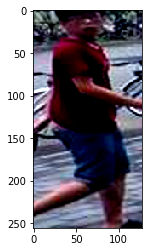

In [5]:
def imshow(img):
    img = img / 2 + 0.5   #-1,1 to 0,1
    npimg = img.numpy()   #转为numpy数组
    plt.imshow(np.transpose(npimg,(1,2,0)))  #3*32*32转为32*32*3
    plt.show()

#show images
imshow(trainset[0][0])

# 搭建模型

In [6]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_out')
        init.constant(m.bias.data, 0.0)
    elif classname.find('BatchNorm1d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal(m.weight.data, std=0.001)
        init.constant(m.bias.data, 0.0)

In [7]:
# Defines the new fc layer and classification layer
# |--Linear--|--bn--|--relu--|--Linear--|
class ClassBlock(nn.Module):
    def __init__(self, input_dim, class_num, dropout=False, relu=False, num_bottleneck=512):
        super(ClassBlock, self).__init__()
        add_block = []
        #add_block += [nn.Linear(input_dim, num_bottleneck)] 
        num_bottleneck=input_dim
        add_block += [nn.BatchNorm1d(num_bottleneck)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if dropout:
            add_block += [nn.Dropout(p=0.5)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(num_bottleneck, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier
    def forward(self, x):
        f = self.add_block(x)
        f_norm = f.norm(p=2, dim=1, keepdim=True) + 1e-8
        f = f.div(f_norm)
        x = self.classifier(f)
        return x,f

In [8]:
class ft_net(nn.Module):

    def __init__(self, class_num ):
        super(ft_net, self).__init__()
        model_ft = models.resnet50(pretrained=True)
        # avg pooling to global pooling
        model_ft.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.model = model_ft
        self.classifier = ClassBlock(2048, class_num, dropout=False, relu=False)
        # remove the final downsample
        # self.model.layer4[0].downsample[0].stride = (1,1)
        # self.model.layer4[0].conv2.stride = (1,1)
    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.squeeze(x)
        x,f = self.classifier(x)
        return x,f

/home/yxy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # Remove the CWD from sys.path while we load stuff.
/home/yxy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  # This is added back by InteractiveShellApp.init_path()
/home/yxy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  app.launch_new_instance()
/home/yxy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


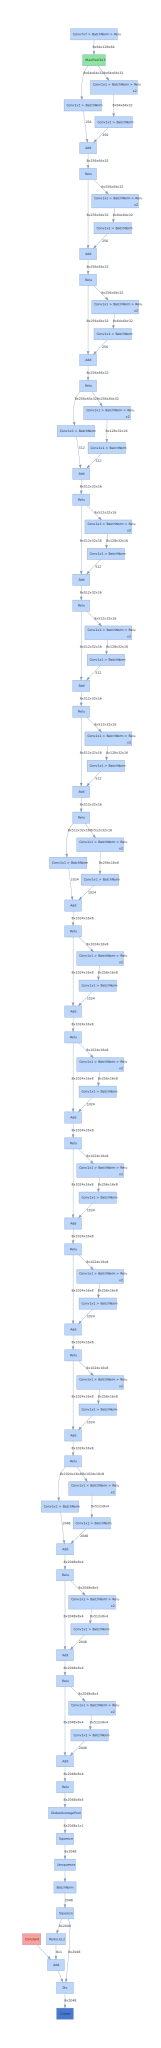

In [9]:
class_names = trainset.classes
net = ft_net(len(class_names))
tw.draw_model(net,[8, 3, 256, 128])

# 网络测试

(tensor([[ 3.3446e-04, -1.7753e-03, -6.0529e-04,  ...,  1.5206e-04,
         -4.9151e-04, -1.2747e-03],
        [ 1.5263e-03,  1.2380e-03,  4.4054e-04,  ...,  4.6667e-04,
         -1.0740e-05, -4.3367e-05],
        [-3.7395e-04, -1.4824e-03, -2.2240e-04,  ..., -8.5626e-04,
         -2.1138e-03, -1.6978e-03],
        ...,
        [-2.3024e-05,  3.6596e-05, -5.2807e-04,  ..., -1.4397e-04,
          1.4475e-03, -1.7779e-03],
        [ 3.6117e-04,  1.5979e-03,  7.5682e-04,  ...,  6.6827e-04,
         -1.2301e-04,  3.3341e-04],
        [-3.5256e-04,  7.8175e-04,  2.1004e-04,  ...,  3.2663e-04,
          2.5566e-04, -6.5701e-04]], grad_fn=<AddmmBackward>), tensor([[-2.0460e-02,  1.3249e-02, -3.1155e-04,  ...,  4.3087e-02,
          2.0742e-02, -2.2418e-02],
        [-2.3214e-02,  3.0830e-02, -7.7530e-03,  ...,  1.7743e-02,
          2.1448e-03, -5.5051e-03],
        [ 4.1802e-02,  8.3887e-03, -4.8664e-03,  ...,  1.7772e-02,
          2.7920e-03, -1.4669e-02],
        ...,
        [-7.3394e-0

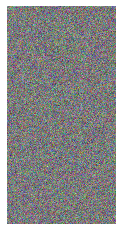

In [10]:
x = torch.randn((10,3,256,128))
x = x / torch.max(x)
im = (x[0]-torch.min(x[0]))/(torch.max(x[0])-torch.min(x[0]))
plt.imshow(np.transpose(im,(1,2,0)))
plt.axis('off')

print(net(x))

# 开始训练

In [11]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
net.to(device) 

ft_net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(6

In [12]:
ignored_params = list(map(id, net.model.fc.parameters() )) + list(map(id, net.classifier.parameters() ))
base_params = filter(lambda p: id(p) not in ignored_params,net.parameters())
optimizer = optim.SGD([
        {'params': base_params, 'lr': 0.1*0.01},
        {'params': net.model.fc.parameters(), 'lr': 0.01},
        {'params': net.classifier.parameters(), 'lr': 0.01}
    ], weight_decay=5e-4, momentum=0.9, nesterov=True)

In [13]:
# save model
def save_network(network, epoch_label):
    save_filename = 'net_%s.pth'% epoch_label
    save_path = os.path.join('./model/',save_filename)
    torch.save(network.state_dict(),save_path)

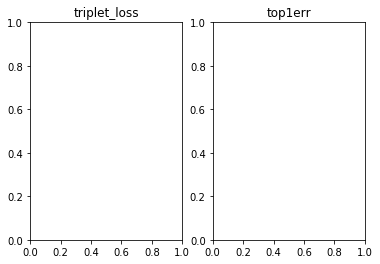

In [14]:
# Draw Curve
x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="triplet_loss")
ax1 = fig.add_subplot(122, title="top1err")
def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss, 'bo-', label='train')
    ax1.plot(x_epoch, y_err, 'bo-', label='train')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    save_jpg = 'train_%s.jpg' % current_epoch
    fig.savefig( os.path.join('./curve/',save_jpg))

In [ ]:
y_loss = []
y_err= []
num_epochs = 61
best_acc = 0.0
last_margin = 0.0
for epoch in range(num_epochs):
    print('Epoch{}/{}'.format(epoch,num_epochs - 1))
    print('-' * 20)
    running_loss = 0.0
    running_corrects = 0.0
    running_margin = 0.0
    running_reg = 0.0
    
    for i,data in enumerate(trainloaders):
        inputs, labels, pos, pos_labels = data
        now_batch_size,c,h,w = inputs.shape
        if now_batch_size < 32: 
            continue
        pos = pos.view(4*32,c,h,w)
        pos_labels = pos_labels.repeat(4).reshape(4,32)
        pos_labels = pos_labels.transpose(0,1).reshape(4*32)
        
        inputs = Variable(inputs.to(device))
        pos = Variable(pos.to(device))
        labels = Variable(labels.to(device))
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        outputs, f = net(inputs)
        
        _, pf = net(pos)
        neg_labels = pos_labels
        
        nf_data = pf #128*512
        rand = np.random.permutation(4*32)[0:128]
        nf_data = nf_data[rand,:]
        neg_labels = neg_labels[rand]
        nf_t = nf_data.transpose(0,1) # 512*128
        score = torch.mm(f.data, nf_t) # cosine 32*128 
        score, rank = score.sort(dim=1, descending = True) # score high == hard
        labels_cpu = labels.cpu()
        nf_hard = torch.zeros(f.shape).to(device)
        for k in range(now_batch_size):
            hard = rank[k,:]
            for kk in hard:
                now_label = neg_labels[kk] 
                anchor_label = labels_cpu[k]
                if now_label != anchor_label:
                    nf_hard[k,:] = nf_data[kk,:]
                    break
        
        pf_hard = torch.zeros(f.shape).to(device) # 32*512
        for k in range(now_batch_size):
            pf_data = pf[4*k:4*k+4,:]
            pf_t = pf_data.transpose(0,1) # 512*4
            ff = f.data[k,:].reshape(1,-1) # 1*512
            score = torch.mm(ff, pf_t) #cosine
            score, rank = score.sort(dim=1, descending = False) #score low == hard
            pf_hard[k,:] = pf_data[rank[0][0],:]
        
        criterion_triplet = nn.MarginRankingLoss(margin=0.3)
        pscore = torch.sum( f * pf_hard, dim=1) 
        nscore = torch.sum( f * nf_hard, dim=1)
        y = torch.ones(now_batch_size)
        y = Variable(y.to(device))
        
        _, preds = torch.max(outputs.data, 1)
        #loss = criterion(outputs, labels)
        #loss_triplet = criterion_triplet(f, pf, nf)
        reg = torch.sum((1+nscore)**2) + torch.sum((-1+pscore)**2)
        loss = torch.sum(torch.nn.functional.relu(nscore + 0.3 - pscore)) 
        loss_triplet = loss
            
        loss_triplet.backward()
        optimizer.step()
        
        running_loss += loss_triplet.item()
        
        running_corrects += float(torch.sum(pscore>nscore+0.3))
        running_margin +=float(torch.sum(pscore-nscore))
        running_reg += reg
        
        datasize = len(trainset)//32 * 32
        epoch_loss = running_loss / datasize
        epoch_reg = (0.0 *running_reg)/ datasize
        epoch_acc = running_corrects / datasize
        epoch_margin = running_margin / datasize
    print('now_margin: %.4f'%0.3)           
    print(' Loss: {:.4f} Reg: {:.4f} Acc: {:.4f} MeanMargin: {:.4f}'.format(
            epoch_loss, epoch_reg, epoch_acc, epoch_margin))
        
    y_loss.append(epoch_loss)
    y_err.append(1.0-epoch_acc)
        
    if epoch_margin>last_margin:
        last_margin = epoch_margin            
        last_model_wts = net.state_dict()

    if epoch%10 == 9:
        save_network(net, epoch)
    draw_curve(epoch)
        
print('train finished')

Epoch0/60
--------------------
now_margin: 0.3000
 Loss: 0.2136 Reg: 0.0000 Acc: 0.2128 MeanMargin: 0.1090
Epoch1/60
--------------------
now_margin: 0.3000
 Loss: 0.0822 Reg: 0.0000 Acc: 0.5045 MeanMargin: 0.2810
Epoch2/60
--------------------
